# 1. Definizione dei percorsi dei file

In [1]:
# Import required libraries
import os

# Parameter definitions
# Sampling rate: all audio files will be resampled to 16 kHz, which is suitable for speech analysis.
sr = 16000  

# STFT parameters:
# n_fft: Window size for Short-Time Fourier Transform. 512 samples corresponds to ~32 ms at 16 kHz.
n_fft = 512  
# hop_length: Step size for the STFT windows. A value of 256 (~50% overlap) ensures good temporal resolution.
hop_length = 256  

# Audio length normalization:
# max_len: The target length of audio files in samples (2 seconds at 16 kHz = 32000 samples).
# Shorter files will be zero-padded, and longer files will be truncated.
max_len = 32000 
max_time_steps = 109  # Define the maximum time steps for your model
# Random seed for reproducibility in random operations (e.g., sampling).
random_state = 2159081  

# Define paths and parameters
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins

# Dataset paths
DATASET_PATH = "/download/hm_dig/LA/LA/"
DATASET_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_train/flac")  # Path to training audio files
DATASET_VAL = os.path.join(DATASET_PATH, "ASVspoof2019_LA_dev/flac")     # Path to validation audio files
DATASET_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_eval/flac")   # Path to test audio files

# Label files contain the protocol for bonafide/spoof labels for each audio file
LABELS_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt")
LABELS_VAL = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt")
LABELS_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt")

# Print paths to verify correctness
print("Train Dataset Path:", DATASET_TRAIN)
print("Labels Train Path:", LABELS_TRAIN)


Train Dataset Path: /download/hm_dig/LA/LA/ASVspoof2019_LA_train/flac
Labels Train Path: /download/hm_dig/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt


# 2. Creazione della lista/dizionario dei file e delle etichette

In [2]:
# Define a function to load labels from the protocol file
def load_labels(file_path):
    labels = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # Example protocol line: <file_id> <label>
            file_id, filename, label = parts[0], parts[1], parts[-1]
            labels[filename] = label
    return labels

# Load training labels
train_labels = load_labels(LABELS_TRAIN)

# Print example
print("Number of training samples:", len(train_labels))
print("Example label:", list(train_labels.items())[:5])

Number of training samples: 25380
Example label: [('LA_T_1138215', 'bonafide'), ('LA_T_1271820', 'bonafide'), ('LA_T_1272637', 'bonafide'), ('LA_T_1276960', 'bonafide'), ('LA_T_1341447', 'bonafide')]


# 3. Separazione dei sample bonafide e spoof

In [3]:
# Separate bonafide and spoof samples
bonafide_samples = {k: v for k, v in train_labels.items() if v == 'bonafide'}
spoof_samples = {k: v for k, v in train_labels.items() if v == 'spoof'}

bonafide_samples = dict(list(bonafide_samples.items())[:len(bonafide_samples)])

# Print counts
print(f"Bonafide samples: {len(bonafide_samples)}")
print(f"Spoof samples: {len(spoof_samples)}")

Bonafide samples: 2580
Spoof samples: 22800


# 4. Equilibratura del dataset

In [4]:
import random

# Balance the dataset by matching the number of spoof samples to bonafide samples
random.seed(random_state)  # For reproducibility
spoof_keys = list(spoof_samples.keys())
random.shuffle(spoof_keys)
balanced_spoof_samples = {k: spoof_samples[k] for k in spoof_keys[:len(bonafide_samples)]}
# balanced_spoof_samples = {k: spoof_samples[k] for k in spoof_keys[:len(bonafide_samples]}

# Combine bonafide and balanced spoof samples
balanced_dataset = {**bonafide_samples, **balanced_spoof_samples}

# Print final counts
print(f"Balanced bonafide samples: {len(bonafide_samples)}")
print(f"Balanced spoof samples: {len(balanced_spoof_samples)}")
print("Example label:", list(balanced_spoof_samples.items())[:5])

Balanced bonafide samples: 2580
Balanced spoof samples: 2580
Example label: [('LA_T_3296816', 'spoof'), ('LA_T_5490522', 'spoof'), ('LA_T_9605518', 'spoof'), ('LA_T_7393204', 'spoof'), ('LA_T_5216820', 'spoof')]


# 5. Caricamento dei file con librosa (progress bar inclusa)

In [5]:
# !pip install tqdm

In [6]:
import librosa
from tqdm import tqdm

# Load audio files with librosa and track progress
def load_audio_files(dataset_path, file_dict, sr=16000, max_len=32000):
    audio_data = {}
    for filename in tqdm(file_dict.keys(), desc="Loading audio files"):
        file_path = os.path.join(dataset_path, f"{filename}.flac")
        try:
            # Load the audio with the target sampling rate
            audio, _ = librosa.load(file_path, sr=sr)
            audio_data[filename] = (audio, sr)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return audio_data

# Load the balanced dataset
audio_data = load_audio_files(DATASET_TRAIN, balanced_dataset, sr=sr, max_len=max_len)

Loading audio files: 100%|█████████████████████████████████████████████████████████| 5160/5160 [01:28<00:00, 58.10it/s]


In [7]:
print(len(audio_data))

5160


# 6. Elaborazione dei dati audio con MEL

In [ ]:
import numpy as np

# Function to compute STFT with updated parameters
def compute_mel(audio_data, n_fft=512, hop_length=256):
    mel_data = []
    for filename, (audio, sr) in tqdm(audio_data.items(), desc="Computing MEL"):
        # Truncate or pad audio to the desired length
        if len(audio) > max_len:
            audio = audio[:max_len]
        elif len(audio) < max_len:
            audio = np.pad(audio, (0, max_len - len(audio)), 'constant') # Added ZeroPadding to normalize file lenght in time

        # Extract Mel spectrogram using librosa
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
        # Ensure all spectrograms have the same width (time steps)
        if mel_spectrogram.shape[1] < max_time_steps:
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
        else:
            mel_spectrogram = mel_spectrogram[:, :max_time_steps]
        
        mel_data.append(mel_spectrogram)
    return mel_data

# Compute STFT for all samples
mel_data = compute_mel(audio_data, n_fft=n_fft, hop_length=hop_length)

Computing MEL:  11%|███████▏                                                        | 578/5160 [00:07<00:49, 93.27it/s]

# 7. Estrazione del silenzio

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

def custom_waveshow(y, sr=22050, max_points=11025, axis='time', offset=0.0, **kwargs):
    """
    Custom implementation of librosa.display.waveshow.
    
    Parameters:
    - y (ndarray): The audio signal (1D array).
    - sr (int): Sampling rate of the signal.
    - max_points (int): Maximum number of points for sample-based view.
    - axis (str): Units for the x-axis ('time' for seconds).
    - offset (float): Offset start time for the waveform.
    - **kwargs: Additional keyword arguments for matplotlib.
    
    Returns:
    - None
    """
    # Determine the total duration of the audio
    duration = len(y) / sr  # in seconds
    
    # Time axis for the waveform
    time = np.arange(len(y)) / sr + offset

    # Adaptive rendering: Check if the plot duration is short
    if duration <= max_points / sr:
        # Detailed sample-based view
        plt.step(time, y, where="post", **kwargs)
    else:
        # Downsample for amplitude envelope
        downsample_factor = max(1, len(y) // max_points)
        
        # Compute the amplitude envelope
        envelope = uniform_filter1d(np.abs(y), size=downsample_factor)
        envelope_time = time[::downsample_factor]  # Time for downsampled points

        # Plot amplitude envelope
        # Remove 'alpha' from kwargs if present to avoid conflict
        
        fill_between_kwargs = kwargs.copy()  
        fill_between_kwargs.pop('alpha', None)  # Remove 'alpha' if it exists

        # plt.fill_between(
        #     envelope_time,
        #     envelope[::downsample_factor],
        #     -envelope[::downsample_factor],
        #     #alpha=0.6, #This may be causing a conflict
        #     **fill_between_kwargs, #Use the modified kwargs without 'alpha' here.
        # )
    
    # # Set axis labels and limits
    # if axis == 'time':
    #     plt.xlabel("Time (s)")
    # elif axis == 'frames':
    #     plt.xlabel("Frames")
    # plt.ylabel("Amplitude")

    # # Add grid for better readability
    # plt.grid(True)
    return envelope

def extract_silence_from_audio(y, sr, threshold):
    amplitude = custom_waveshow(y, sr=sr, max_points=11025, color="blue", alpha=0.8)
    tmp = amplitude
    sil = np.zeros(len(tmp))
    counter = 0
    for i in range(0, len(tmp)):
      if tmp[i] < threshold:
        sil[counter] = tmp[i]
        counter = counter + 1
    C = sil[:counter]
    return C


# 8. Scaling dei dati audio con normalizzazione della durata
### Goal: mean = 0 and devstd = 1

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Function to scale and normalize audio data
def scale_and_normalize_audio_data(audio_data, scaler, max_len=32000):
    scaled_audio_data = {}
    
    for filename, (audio, sr) in tqdm(audio_data.items(), desc="Scaling and normalizing audio data"):
        # Ensure audio length matches max_len
        if len(audio) > max_len:
            audio = audio[:max_len]
        elif len(audio) < max_len:
            audio = np.pad(audio, (0, max_len - len(audio)), 'constant')
        
        # Normalize audio values to have mean 0 and std 1
        audio = audio.reshape(-1, 1)  # Reshape for StandardScaler
        audio = scaler.fit_transform(audio).flatten()  # Use fit_transform here for training data
        
        scaled_audio_data[filename] = (audio, sr)
    
    return scaled_audio_data

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling and normalization to audio data
scaled_audio_data = scale_and_normalize_audio_data(audio_data, scaler, max_len=max_len)

# Example check: print statistics of a scaled and normalized sample
example_filename = next(iter(scaled_audio_data))
example_audio_scaled, example_sr_scaled = scaled_audio_data[example_filename]
example_audio, example_sr = audio_data[example_filename]
print(f"Sample: {example_filename}")
print(f"Length: {len(example_audio)} (expected: {max_len})")
print(f"Mean: {np.mean(example_audio):.2f}, Std: {np.std(example_audio):.2f}")
print(f"Length of scaled file: {len(example_audio_scaled)} (expected: {max_len})")
print(f"Mean of scaled file: {np.mean(example_audio_scaled):.2f}, Std of scaled file: {np.std(example_audio_scaled):.2f}")


In [ ]:
print(len(scaled_audio_data))

# 10. Preparazione dei dataset di validation e test con shuffle e limitazione

In [ ]:
import random
import matplotlib.pyplot as plt

# Function to process validation and test datasets with sample limit, shuffle, and padding/truncation
def prepare_dataset(dataset_path, labels_path, scaler, sr=16000, max_len=32000, max_samples=None):
    # Load labels
    labels = load_labels(labels_path)
    
    # Shuffle and limit the number of samples
    file_keys = list(labels.keys())
    random.shuffle(file_keys)
    if max_samples:
        file_keys = file_keys[:max_samples]
    labels = {key: labels[key] for key in file_keys}
    
    # Load audio files
    audio_data = load_audio_files(dataset_path, labels, sr=sr, max_len=max_len)
    
    # Scale, pad, or truncate audio data
    scaled_audio_data = {}
    for filename, (audio, sr) in tqdm(audio_data.items(), desc=f"Processing {dataset_path}"):
        
        # Ensure audio length matches max_len
        if len(audio) > max_len:
            audio = audio[:max_len]  # Truncate if longer
        elif len(audio) < max_len:
            audio = np.pad(audio, (0, max_len - len(audio)), 'constant')  # Pad with zeros if shorter
            
        # Normalize audio values to have mean 0 and std 1 using the provided scaler
        audio = audio.reshape(-1, 1)
        audio = scaler.transform(audio).flatten()  # Use transform (not fit_transform)
        
        # Store scaled audio
        scaled_audio_data[filename] = (audio, sr)
    
    return scaled_audio_data, labels

# Calculate the number of training samples
num_training_samples = len(bonafide_samples)  # From the balanced dataset

# Limit for validation and test samples
max_samples = num_training_samples * 2

# Prepare validation dataset
validation_data, validation_labels = prepare_dataset(
    DATASET_VAL, LABELS_VAL, scaler, sr=sr, max_len=max_len, max_samples=max_samples
)

# Prepare test dataset
test_data, test_labels = prepare_dataset(
    DATASET_TEST, LABELS_TEST, scaler, sr=sr, max_len=max_len, max_samples=max_samples
)

# Function to visualize samples
def visualize_dataset_samples(data, labels, title, num_samples=5):
    sample_keys = random.sample(list(data.keys()), min(num_samples, len(data)))
    for sample_key in sample_keys:
        audio, sr = data[sample_key]
        stft = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))
        plt.figure(figsize=(10, 4))
        plt.title(f"{title}: {sample_key} ({labels[sample_key]})")
        plt.imshow(10 * np.log10(stft + 1e-10), aspect='auto', origin='lower')
        plt.colorbar(label='Magnitude (dB)')
        plt.xlabel('Time Frames')
        plt.ylabel('Frequency Bins')
        plt.show()

# Visualize 5 samples from validation and test datasets
print("Validation dataset samples:")
visualize_dataset_samples(validation_data, validation_labels, title="Validation Dataset")

print("Test dataset samples:")
visualize_dataset_samples(test_data, test_labels, title="Test Dataset")


# model 1: 

In [ ]:
X_sil_train = extract_silence_from_audio(scaled_audio_data, sr, 0.0 )
# y_mel_train = compute_mel(balanced_dataset, n_fft=n_fft, hop_length=hop_length)
X_sil_val = extract_silence_from_audio(validation_data, n_fft=n_fft, hop_length=hop_length)
# y_mel_val = compute_mel(validation_labels, n_fft=n_fft, hop_length=hop_length)
X_sil_test = extract_silence_from_audio(test_data, n_fft=n_fft, hop_length=hop_length)
# y_mel_test = compute_mel(test_labels, n_fft=n_fft, hop_length=hop_length)

In [14]:
#compute the mel 

X_mel_train = compute_mel(scaled_audio_data, n_fft=n_fft, hop_length=hop_length)
# y_mel_train = compute_mel(balanced_dataset, n_fft=n_fft, hop_length=hop_length)
X_mel_val = compute_mel(validation_data, n_fft=n_fft, hop_length=hop_length)
# y_mel_val = compute_mel(validation_labels, n_fft=n_fft, hop_length=hop_length)
X_mel_test = compute_mel(test_data, n_fft=n_fft, hop_length=hop_length)
# y_mel_test = compute_mel(test_labels, n_fft=n_fft, hop_length=hop_length)

Computing MEL: 100%|███████████████████████████████████████████████████████████████| 5160/5160 [00:58<00:00, 88.66it/s]


In [16]:

def get_array(my_dict):
    items_list = list(my_dict.items())
    arr = np.zeros((len(items_list), 109))
    for i in range(0, len(items_list)):
        arr[i] = items_list[i][1][0]
    return arr
        
def get_Y_array(my_dict):
    items_list = list(my_dict.items())
    lis = []
    for i in range(0, len(items_list)):
        lis.append(items_list[i][1][0])
    arr = np.array(lis)
    return arr
        
X_train = np.array(X_mel_train)
X_val = np.array(X_mel_val)
X_test = np.array(X_mel_test)

y_train_str = get_Y_array(balanced_dataset)
y_val_str = get_Y_array(validation_labels)
y_test_str = get_Y_array(test_labels)


print( np.equal(y_train_str[1],"b"))
def get_numerical_label(arr):
    for i in range(0, len(arr)):
        if np.equal(arr[i],"b"):
            arr[i] = 1
        elif np.equal(arr[i],"s"):
            arr[i] = 0
            # print("haha")
        
    return arr

y_train_n = get_numerical_label(y_train_str)
y_val_n = get_numerical_label(y_val_str)
y_test_n = get_numerical_label(y_test_str)

print(len(y_test_n))
print(len(y_val_n))
print(len(y_train_n))
print(len(X_test))
print(len(X_val))
print(len(X_test))
# print(y_test_num)

True
5160
5160
5160
5160
5160
5160


In [26]:
# y_train_n = y_train_n[:10320]

In [17]:
# !pip install seaborn
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [18]:
y_train_num = to_categorical(y_train_str, NUM_CLASSES)
y_val_num = to_categorical(y_val_str, NUM_CLASSES)
y_test_num = to_categorical(y_test_str, NUM_CLASSES)


print(X_train.dtype)  # Per vedere il tipo di dato di X_train
print(y_train_num.dtype)  # Per vedere il tipo di dato di y_train

float32
float64


In [19]:
# Define CNN model architecture
input_shape = (N_MELS, X_train.shape[2], 1)  # Input shape for CNN (height, width, channels)
model_input = Input(shape=input_shape)

In [20]:
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

In [21]:
model = Model(inputs=model_input, outputs=model_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train_num, batch_size=32, epochs=10, validation_data=(X_val, y_val_num))

# saving the model
model.save("audio_classifier.h5")

Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 54s 313ms/step - accuracy: 0.6798 - loss: 8.2367 - val_accuracy: 0.5609 - val_loss: 0.6776
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 43s 266ms/step - accuracy: 0.8264 - loss: 0.3720 - val_accuracy: 0.8816 - val_loss: 0.2466
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 43s 268ms/step - accuracy: 0.9073 - loss: 0.2205 - val_accuracy: 0.9151 - val_loss: 0.1799
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 41s 254ms/step - accuracy: 0.9180 - loss: 0.1792 - val_accuracy: 0.9411 - val_loss: 0.1428
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 42s 256ms/step - accuracy: 0.9429 - loss: 0.1686 - val_accuracy: 0.9328 - val_loss: 0.1479
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 41s 255ms/step - accuracy: 0.9463 - loss: 0.1190 - val_accuracy: 0.8541 - val_loss: 0.2957
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 42s 261ms/step - accuracy: 0.9332 - loss: 0.1725 - val_accuracy: 0.9279 - val_loss: 0.1504
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 42s 259ms/step - accuracy: 0.9521 - loss: 0

In [23]:
from tensorflow.keras.models import load_model

MODEL_PATH = "audio_classifier.h5"

model = load_model(MODEL_PATH)
# Predict using the loaded model
y_pred = model.predict(X_test)

# Convert probabilities to predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step


In [26]:
print(y_pred)

[[3.4355983e-01 6.5644014e-01]
 [9.9999595e-01 3.9944098e-06]
 [4.5039756e-03 9.9549603e-01]
 ...
 [1.0000000e+00 2.0928755e-11]
 [9.8106027e-01 1.8939732e-02]
 [8.2431161e-01 1.7568834e-01]]


[0 0 1 ... 0 0 0]


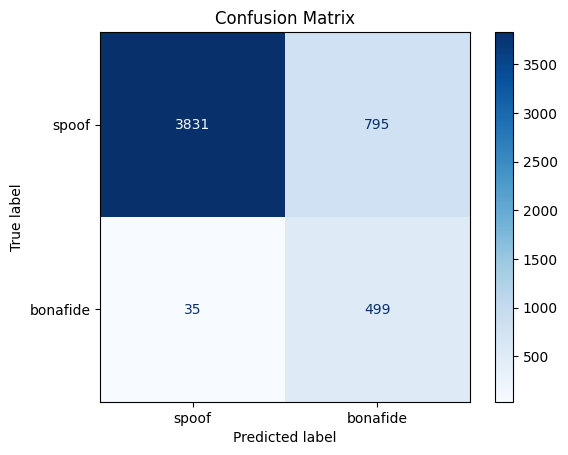

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# CONFUSION MATRIX
y_true = np.array([1 if np.equal(label,'1') else 0 for label in y_test_n])
print(y_true)
# y_true = np.array(y_test_n)
# print(y_true)
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
classes = ["spoof", "bonafide"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step


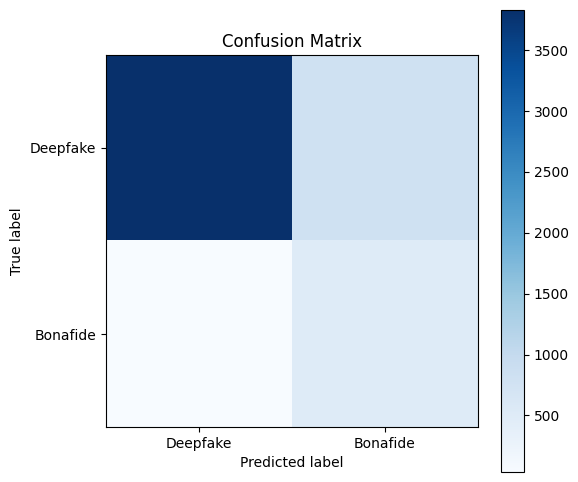

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      4626
           1       0.39      0.93      0.55       534

    accuracy                           0.84      5160
   macro avg       0.69      0.88      0.72      5160
weighted avg       0.93      0.84      0.87      5160



ValueError: y should be a 1d array, got an array of shape (5160, 2) instead.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict the probabilities for the test set
y_pred_prob = model.predict(X_test)

# # Convert probabilities to binary predictions (0 or 1)
y_pred = y_pred_classes
y_test = y_true

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['Deepfake', 'Bonafide'])
plt.yticks([0, 1], ['Deepfake', 'Bonafide'])
plt.show()

# 2. Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# 3. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# 4. Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# 5. Precision, Recall, and F1-Score metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


# 11. Implementazione e valutazione della SVM

2025-01-16 12:30:09.573084: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 12:30:09.753786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737027009.821135   10536 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737027009.841290   10536 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 12:30:10.005983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Testing parameters: learning_rate=0.01, l2_lambda=0.1


I0000 00:00:1737027016.210526   10536 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5523 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1737027017.920153   10651 service.cc:148] XLA service 0x7f0018003b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737027017.920476   10651 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-01-16 12:30:17.937524: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737027017.972072   10651 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1737027018.138721   10651 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Testing parameters: learning_rate=0.01, l2_lambda=0.01
Testing parameters: learning_rate=0.01, l2_lambda=0.001
Testing parameters: learning_rate=0.001, l2_lambda=0.1
Testing parameters: learning_rate=0.001, l2_lambda=0.01
Testing parameters: learning_rate=0.001, l2_lambda=0.001
Testing parameters: learning_rate=0.0001, l2_lambda=0.1
Testing parameters: learning_rate=0.0001, l2_lambda=0.01
Testing parameters: learning_rate=0.0001, l2_lambda=0.001

Grid Search Results:
Learning Rate: 0.01, L2 Lambda: 0.1, Validation Accuracy: 0.052
Learning Rate: 0.01, L2 Lambda: 0.01, Validation Accuracy: 0.050
Learning Rate: 0.01, L2 Lambda: 0.001, Validation Accuracy: 0.054
Learning Rate: 0.001, L2 Lambda: 0.1, Validation Accuracy: 0.045
Learning Rate: 0.001, L2 Lambda: 0.01, Validation Accuracy: 0.047
Learning Rate: 0.001, L2 Lambda: 0.001, Validation Accuracy: 0.047
Learning Rate: 0.0001, L2 Lambda: 0.1, Validation Accuracy: 0.039
Learning Rate: 0.0001, L2 Lambda: 0.01, Validation Accuracy: 0.041
Le

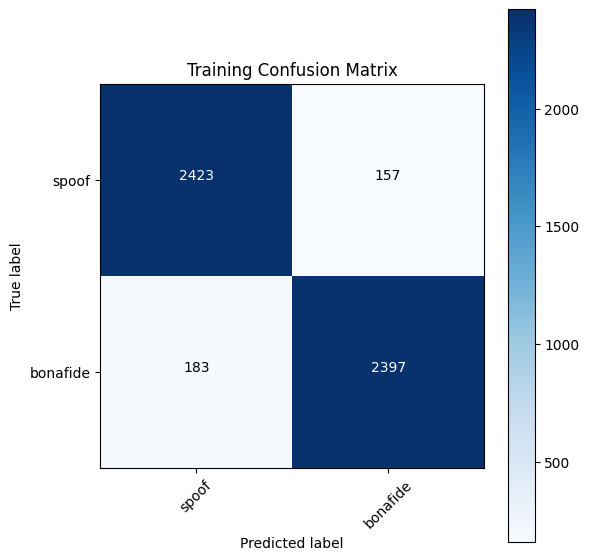


Test Results:
Accuracy: 0.488


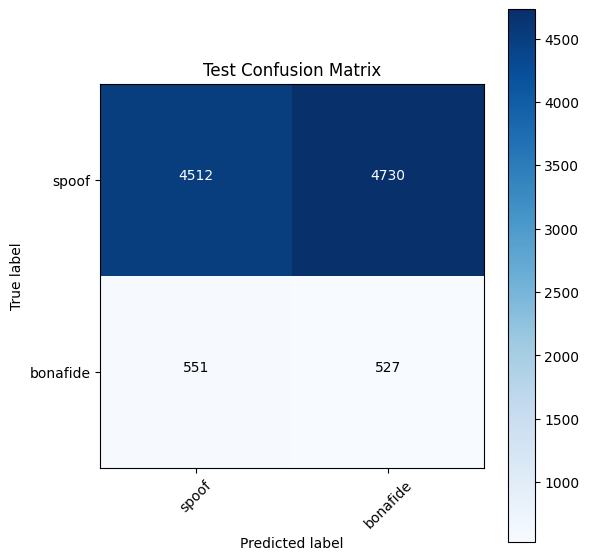

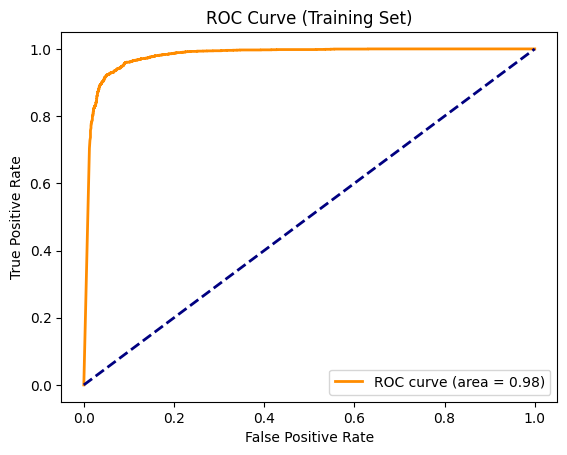

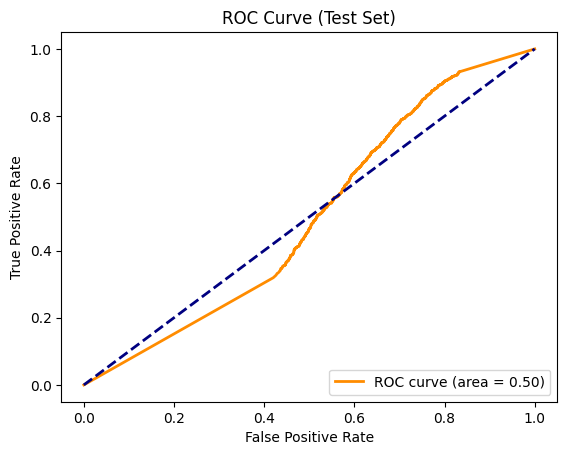

'\n# QUESTA IMPLEMENTAZIONE RICHIEDE TROPPA RAM\n\nfrom sklearn.svm import SVC\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Function to plot the ROC curve\ndef plot_roc_curve(y_true, y_scores, title):\n    fpr, tpr, _ = roc_curve(y_true, y_scores)\n    roc_auc = auc(fpr, tpr)\n    plt.figure()\n    plt.plot(fpr, tpr, color=\'darkorange\', lw=2, label=f\'ROC curve (area = {roc_auc:.2f})\')\n    plt.plot([0, 1], [0, 1], color=\'navy\', lw=2, linestyle=\'--\')\n    plt.xlabel(\'False Positive Rate\')\n    plt.ylabel(\'True Positive Rate\')\n    plt.title(title)\n    plt.legend(loc="lower right")\n    plt.show()\n\n# Flatten datasets for SVM (converts audio data into feature arrays)\ndef flatten_dataset(data, labels):\n    X = np.array([audio for audio, _ in data.values()])\n    y = np.array([1 if labels[file] == \'bonafide\' el

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from tqdm import tqdm

# Function to plot the ROC curve
def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Flatten datasets for SVM
def flatten_dataset(data, labels):
    X = np.array([audio for audio, _ in data.values()])
    y = np.array([1 if labels[file] == 'bonafide' else 0 for file in data.keys()])
    return X, y

# Flatten training, validation, and test datasets
X_train, y_train = flatten_dataset(scaled_audio_data, balanced_dataset)
X_val, y_val = flatten_dataset(validation_data, validation_labels)
X_test, y_test = flatten_dataset(test_data, test_labels)

# Convert labels to {-1, 1} for hinge loss
y_train = 2 * y_train - 1
y_val = 2 * y_val - 1
y_test = 2 * y_test - 1

# Define the TensorFlow SVM model
class SVMModel(tf.keras.Model):
    def __init__(self, input_dim, l2_lambda=0.01):
        super(SVMModel, self).__init__()
        self.dense = tf.keras.layers.Dense(1, activation=None, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))

    def call(self, inputs):
        return self.dense(inputs)

# Grid search for learning rate and L2 regularization
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'l2_lambda': [0.1, 0.01, 0.001]
}

best_params = None
best_val_accuracy = 0
history_logs = []

for learning_rate in param_grid['learning_rate']:
    for l2_lambda in param_grid['l2_lambda']:
        print(f"Testing parameters: learning_rate={learning_rate}, l2_lambda={l2_lambda}")
        
        # Initialize model and optimizer
        svm_model = SVMModel(input_dim=X_train.shape[1], l2_lambda=l2_lambda)
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
        # Compile the model
        svm_model.compile(optimizer=optimizer, loss=tf.keras.losses.Hinge(), metrics=['accuracy'])
        
        # Train the model
        history = svm_model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=128,
            verbose=0
        )
        val_accuracy = history.history['val_accuracy'][-1]
        history_logs.append((learning_rate, l2_lambda, val_accuracy))
        
        # Update best parameters
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = {'learning_rate': learning_rate, 'l2_lambda': l2_lambda}

# Print best parameters and all results
print("\nGrid Search Results:")
for log in history_logs:
    print(f"Learning Rate: {log[0]}, L2 Lambda: {log[1]}, Validation Accuracy: {log[2]:.3f}")
print("\nBest Parameters:", best_params)

# Train the final model with the best parameters
svm_model = SVMModel(input_dim=X_train.shape[1], l2_lambda=best_params['l2_lambda'])
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
svm_model.compile(optimizer=optimizer, loss=tf.keras.losses.Hinge(), metrics=['accuracy'])
svm_model.fit(X_train, y_train, epochs=20, batch_size=128, verbose=1)

# Evaluate on training set
y_train_pred = svm_model.predict(X_train).flatten()
y_train_scores = tf.nn.sigmoid(y_train_pred).numpy()
train_accuracy = accuracy_score(y_train, np.sign(y_train_pred))
train_cm = confusion_matrix(y_train, np.sign(y_train_pred))

# Evaluate on test set
y_test_pred = svm_model.predict(X_test).flatten()
y_test_scores = tf.nn.sigmoid(y_test_pred).numpy()
test_accuracy = accuracy_score(y_test, np.sign(y_test_pred))
test_cm = confusion_matrix(y_test, np.sign(y_test_pred))

# Print results
print("\nTraining Results:")
print(f"Accuracy: {train_accuracy:.3f}")
plot_confusion_matrix(train_cm, labels=['spoof', 'bonafide'], title="Training Confusion Matrix")

print("\nTest Results:")
print(f"Accuracy: {test_accuracy:.3f}")
plot_confusion_matrix(test_cm, labels=['spoof', 'bonafide'], title="Test Confusion Matrix")

# Plot ROC for training and test sets
plot_roc_curve(y_train, y_train_scores, title="ROC Curve (Training Set)")
plot_roc_curve(y_test, y_test_scores, title="ROC Curve (Test Set)")


'''
# QUESTA IMPLEMENTAZIONE RICHIEDE TROPPA RAM

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Function to plot the ROC curve
def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Function to extract compact features from STFT
def extract_features(data, labels, n_components=50):
    # Flatten the STFT into a compact representation using PCA
    X = np.array([audio for audio, _ in data.values()])
    y = np.array([1 if labels[file] == 'bonafide' else 0 for file in data.keys()])
    
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    print(f"PCA reduced dimensions to: {X_reduced.shape[1]} components")
    
    return X_reduced, y, pca

# Extract features for training, validation, and test sets
X_train, y_train, pca = extract_features(scaled_audio_data, balanced_dataset)
X_val, y_val, _ = extract_features(validation_data, validation_labels, n_components=pca.n_components_)
X_test, y_test, _ = extract_features(test_data, test_labels, n_components=pca.n_components_)

# Reduce validation set for grid search
val_subset_size = int(0.3 * len(X_val))
X_val_subset, y_val_subset = X_val[:val_subset_size], y_val[:val_subset_size]

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Perform grid search using reduced validation set
svm = SVC(probability=True)
grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_val_subset, y_val_subset)

# Print grid search results
print("Grid Search Results:")
for mean, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
    print(f"Accuracy: {mean:.3f} | Params: {params}")

# Best parameters and model
best_params = grid_search.best_params_
print("\nBest Parameters:", best_params)

# Train SVM with best parameters
best_svm = SVC(**best_params, probability=True)
best_svm.fit(X_train, y_train)

# Evaluate on training set
y_train_pred = best_svm.predict(X_train)
y_train_scores = best_svm.predict_proba(X_train)[:, 1]
train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = 1 - train_accuracy

# Evaluate on test set
y_test_pred = best_svm.predict(X_test)
y_test_scores = best_svm.predict_proba(X_test)[:, 1]
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy

# Print results
print("\nTraining Results:")
print(f"Accuracy: {train_accuracy:.3f}, Error: {train_error:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

print("\nTest Results:")
print(f"Accuracy: {test_accuracy:.3f}, Error: {test_error:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Plot ROC for training and test sets
plot_roc_curve(y_train, y_train_scores, title="ROC Curve (Training Set)")
plot_roc_curve(y_test, y_test_scores, title="ROC Curve (Test Set)")
'''

'''
# QUESTA IMPLEMENTAZIONE RICHIEDE TROPPA RAM

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the ROC curve
def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Flatten datasets for SVM (converts audio data into feature arrays)
def flatten_dataset(data, labels):
    X = np.array([audio for audio, _ in data.values()])
    y = np.array([1 if labels[file] == 'bonafide' else 0 for file in data.keys()])
    return X, y

# Flatten validation and training datasets
X_train, y_train = flatten_dataset(scaled_audio_data, balanced_dataset)
X_val, y_val = flatten_dataset(validation_data, validation_labels)
X_test, y_test = flatten_dataset(test_data, test_labels)

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Perform grid search using validation set
svm = SVC(probability=True)
grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_val, y_val)

# Print all results from grid search
print("Grid Search Results:")
for mean, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
    print(f"Accuracy: {mean:.3f} | Params: {params}")

# Best parameters and model
best_params = grid_search.best_params_
print("\nBest Parameters:", best_params)

# Train SVM with best parameters
best_svm = SVC(**best_params, probability=True)
best_svm.fit(X_train, y_train)

# Evaluate on training set
y_train_pred = best_svm.predict(X_train)
y_train_scores = best_svm.predict_proba(X_train)[:, 1]
train_accuracy = accuracy_score(y_train, y_train_pred)
train_error = 1 - train_accuracy

# Evaluate on test set
y_test_pred = best_svm.predict(X_test)
y_test_scores = best_svm.predict_proba(X_test)[:, 1]
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy

# Print results
print("\nTraining Results:")
print(f"Accuracy: {train_accuracy:.3f}, Error: {train_error:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

print("\nTest Results:")
print(f"Accuracy: {test_accuracy:.3f}, Error: {test_error:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Plot ROC for training and test sets
plot_roc_curve(y_train, y_train_scores, title="ROC Curve (Training Set)")
plot_roc_curve(y_test, y_test_scores, title="ROC Curve (Test Set)")
'''

# Implementazione SVM senza validazione

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2298 - loss: 6.0996 - val_accuracy: 0.0492 - val_loss: 16.2177
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3406 - loss: 4.6100 - val_accuracy: 0.0484 - val_loss: 16.5113
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3453 - loss: 4.2875 - val_accuracy: 0.0467 - val_loss: 18.7713
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3681 - loss: 4.2507 - val_accuracy: 0.0489 - val_loss: 20.2678
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3677 - loss: 4.1301 - val_accuracy: 0.0480 - val_loss: 19.5146
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3776 - loss: 4.3118 - val_accuracy: 0.0484 - val_loss: 20.7430
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3877 - loss: 4.4511 - val_accuracy: 0.0490 - val_loss: 21.4463
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3854 - loss: 3.8141 - val_accuracy: 0.0

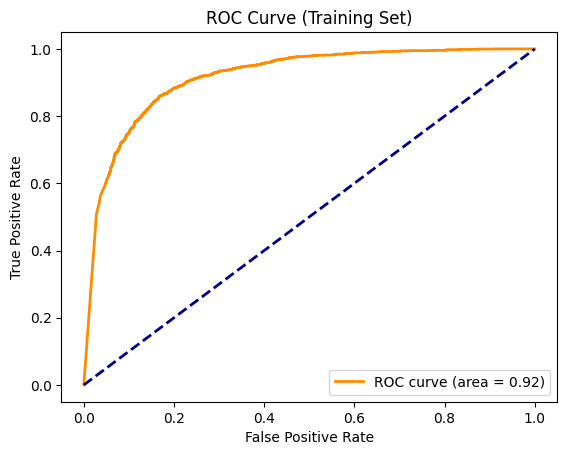

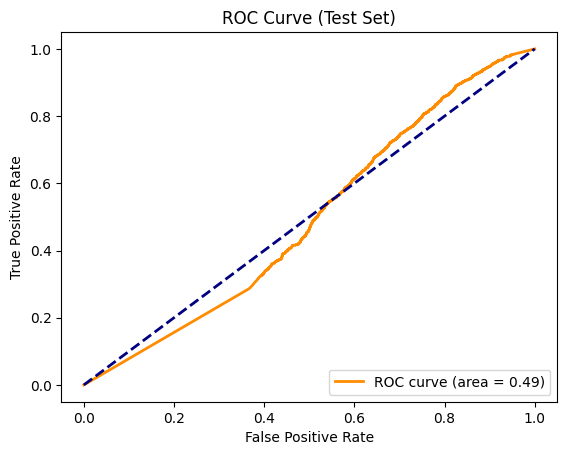

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from tqdm import tqdm

# Function to plot the ROC curve
def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Flatten datasets for SVM
def flatten_dataset(data, labels):
    X = np.array([audio for audio, _ in data.values()])
    y = np.array([1 if labels[file] == 'bonafide' else 0 for file in data.keys()])
    return X, y

# Flatten training and test datasets
X_train, y_train = flatten_dataset(scaled_audio_data, balanced_dataset)
X_test, y_test = flatten_dataset(test_data, test_labels)

# Convert labels to {-1, 1} for hinge loss
y_train = 2 * y_train - 1
y_test = 2 * y_test - 1

# Define the TensorFlow model
class SVMModel(tf.keras.Model):
    def __init__(self, input_dim):
        super(SVMModel, self).__init__()
        self.dense = tf.keras.layers.Dense(1, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01))

    def call(self, inputs):
        return self.dense(inputs)

# Initialize the model
input_dim = X_train.shape[1]
svm_model = SVMModel(input_dim)

# Define optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
hinge_loss = tf.keras.losses.Hinge()

# Compile the model
svm_model.compile(optimizer=optimizer, loss=hinge_loss, metrics=['accuracy'])

# Train the model with progress bar
history = svm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=128,
    verbose=1
)

# Evaluate on training set
y_train_pred = svm_model.predict(X_train).flatten()
y_train_scores = tf.nn.sigmoid(y_train_pred).numpy()
train_accuracy = accuracy_score(y_train, np.sign(y_train_pred))
train_error = 1 - train_accuracy

# Evaluate on test set
y_test_pred = svm_model.predict(X_test).flatten()
y_test_scores = tf.nn.sigmoid(y_test_pred).numpy()
test_accuracy = accuracy_score(y_test, np.sign(y_test_pred))
test_error = 1 - test_accuracy

# Print results
print("\nTraining Results:")
print(f"Accuracy: {train_accuracy:.3f}, Error: {train_error:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_train, np.sign(y_train_pred)))

print("\nTest Results:")
print(f"Accuracy: {test_accuracy:.3f}, Error: {test_error:.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, np.sign(y_test_pred)))

# Plot ROC for training and test sets
plot_roc_curve(y_train, y_train_scores, title="ROC Curve (Training Set)")
plot_roc_curve(y_test, y_test_scores, title="ROC Curve (Test Set)")

In [13]:
# Provare con oneclass SVM, RandomForest, IsolationForest, CNN, RNN, Autoencoder
# Differenza tra standard scaler e minmaxscaler?

# 13. Implementazione di One-Class SVM (senza validation)

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Function to plot the ROC curve
def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Filter training data for bonafide samples only
def filter_bonafide_data(data, labels):
    filtered_data = {key: value for key, value in data.items() if labels[key] == 'bonafide'}
    X = np.array([audio for audio, _ in filtered_data.values()])
    return X

# Flatten datasets
X_train_bonafide = filter_bonafide_data(scaled_audio_data, balanced_dataset)
X_test, y_test = flatten_dataset(test_data, test_labels)

print("Flattened all data")

# Convert labels to binary for evaluation (1 = bonafide, 0 = spoof)
y_test_binary = np.array([1 if label == 'bonafide' else 0 for label in test_labels.values()])

print("Filtered all data")

# Define and train One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05, cache_size=1000, verbose=True, max_iter=15 )  # Adjust nu for the expected fraction of outliers
print("Created model. Start fitting...")
oc_svm.fit(X_train_bonafide)
print("Finished fitting")

# Predict on training set (bonafide only)
train_scores = oc_svm.decision_function(X_train_bonafide)  # Higher scores indicate better fit to the training distribution
train_preds = oc_svm.predict(X_train_bonafide)
train_preds = (train_preds == 1).astype(int)  # Convert predictions to binary: 1 = bonafide, 0 = outlier

# Predict on test set
test_scores = oc_svm.decision_function(X_test)
test_preds = oc_svm.predict(X_test)
test_preds = (test_preds == 1).astype(int)  # Convert predictions to binary: 1 = bonafide, 0 = outlier

# Evaluate on test set
test_accuracy = accuracy_score(y_test_binary, test_preds)
test_cm = confusion_matrix(y_test_binary, test_preds)

# Print training results
print("\nTraining Results (Bonafide Only):")
print(f"Number of bonafide samples: {len(X_train_bonafide)}")
print(f"Training Predictions: {np.sum(train_preds == 1)} bonafide, {np.sum(train_preds == 0)} outliers")

# Print test results
print("\nTest Results:")
print(f"Accuracy: {test_accuracy:.3f}")
print("Confusion Matrix:\n", test_cm)
print("\nClassification Report:\n", classification_report(y_test_binary, test_preds, target_names=['spoof', 'bonafide']))

# Plot ROC curve for test set
plot_roc_curve(y_test_binary, test_scores, title="ROC Curve (Test Set)")

Flattened all data
Filtered all data
Created model. Start fitting...
[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 15
obj = 1177.300140, rho = 17.881568
nSV = 144, nBSV = 113
Finished fitting


/home/matteo/miniconda3/envs/sklearn-env/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
